In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
path = "/kaggle/input/flowers-recognition/flowers"
class_name = os.listdir(path)
class_name

['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']

In [3]:
from keras.utils import image_dataset_from_directory

img_size = 150

train_ds = image_dataset_from_directory(
    directory="/kaggle/input/flowers-recognition/flowers",
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(img_size, img_size),
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=123,
)


test_ds = image_dataset_from_directory(
    directory="/kaggle/input/flowers-recognition/flowers",
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(img_size, img_size),
    shuffle=False,         
    validation_split=0.2,  
    subset="validation",
    seed=123,
)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [4]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

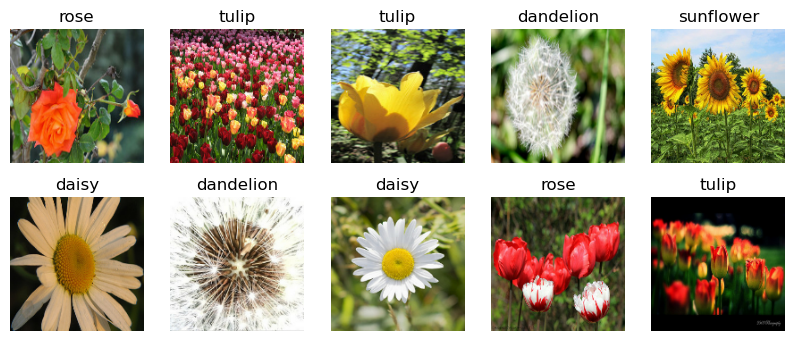

In [5]:
plt.figure(figsize=[10,4])
for image, label in train_ds.take(1):
    for i in range(10):
        ax=plt.subplot(2, 5, i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        ax.axis("off")


In [6]:
normalize = lambda x, y: (x / 255, y)

normalize_train_ds = train_ds.map(normalize)
normalize_test_ds = test_ds.map(normalize)

In [7]:
for batch_images, batch_labels in normalize_train_ds.take(1):
    max_pixel_value = np.max(batch_images)
    min_pixel_value = np.min(batch_images)
    print("Maximum pixel value:", max_pixel_value)
    print("Minimum pixel value:", min_pixel_value)

Maximum pixel value: 1.0
Minimum pixel value: 0.0


In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout 
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam, RMSprop
from keras.layers import Input

In [9]:
class MyModel(Model):
    def __init__(self, img_size):
        super(MyModel,self).__init__()
        
        self.img_size = img_size
        self.input_layer = Input(shape=(img_size, img_size, 3))
        
        self.conv1 = Conv2D(64, kernel_size=(3,3), padding="valid", strides=2, activation= tf.nn.relu)(self.input_layer)
        self.pool1 = MaxPooling2D(pool_size=(2,2))(self.conv1)
        self.drop1 = Dropout(rate=0.2)(self.pool1)
        
        self.conv2 = Conv2D(64, kernel_size=(3,3), padding="valid", strides=2, activation= tf.nn.relu)(self.drop1)
        self.pool2 = MaxPooling2D(pool_size=(2,2))(self.conv2)
        self.drop2 = Dropout(rate=0.1)(self.pool2)
        
        self.flatten = Flatten()(self.drop2)
            
        self.dense1 = Dense(units=128, activation= tf.nn.relu)(self.flatten)
        self.drop3 = Dropout(rate=0.3)(self.dense1)
        self.output_layer = Dense(units=5, activation=tf.nn.softmax)(self.drop3)
        
        self.model = Model(inputs=self.input_layer, outputs = self.output_layer)
      
    def call(self, x):
        return self.model(x)
            
model = MyModel(img_size=img_size)
model.build((None,img_size, img_size, 3))
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 5)                 703045    
                                                                 
Total params: 703,045
Trainable params: 703,045
Non-trainable params: 0
_________________________________________________________________


In [10]:
loss_object = SparseCategoricalCrossentropy(from_logits=True)
optimizer_object = Adam()


train_loss = keras.metrics.Mean(name="Train Loss")
train_accuracy = keras.metrics.SparseCategoricalAccuracy(name="Train Accuracy")

test_loss = keras.metrics.Mean(name="Test Loss")
test_accuracy = keras.metrics.SparseCategoricalAccuracy(name="Test Accuracy")

In [11]:
tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        prediction = model(images, training=True)
        loss = loss_object(labels, prediction)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer_object.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, prediction)

In [12]:
tf.function
def test_step(images, labels):
    prediction = model(images, training=False)
    loss = loss_object(labels, prediction)
    
    test_loss(loss)
    test_accuracy(labels, prediction)

In [13]:
#More epochs will definitely increase the accuracy
epochs = 20

loss_arr, accuracy_arr, test_loss_arr, test_accuracy_arr = [], [], [], []

for i in range(epochs):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    
    for train_images, train_labels in normalize_train_ds:
        train_step(train_images, train_labels)
        
    for test_images, test_labels in normalize_test_ds:
        test_step(test_images, test_labels)
        
    print(
        f"Epoch {i+1}, "
        f"Loss {train_loss.result():.2f}, "
        f"Accuracy {train_accuracy.result():.2f}, "
        f"Test loss {test_loss.result():2f}, "
        f"Test Accuracy {test_accuracy.result():.2f}"
    )
    
    loss_arr.append(train_loss.result())
    accuracy_arr.append(train_accuracy.result())
    test_loss_arr.append(test_loss.result()) 
    test_accuracy_arr.append(test_accuracy.result())


Epoch 1, Loss 1.55, Accuracy 0.33, Test loss 1.403682, Test Accuracy 0.50
Epoch 2, Loss 1.46, Accuracy 0.43, Test loss 1.244147, Test Accuracy 0.66
Epoch 3, Loss 1.35, Accuracy 0.55, Test loss 1.316059, Test Accuracy 0.58
Epoch 4, Loss 1.31, Accuracy 0.59, Test loss 1.311920, Test Accuracy 0.58
Epoch 5, Loss 1.29, Accuracy 0.61, Test loss 1.287242, Test Accuracy 0.61
Epoch 6, Loss 1.27, Accuracy 0.63, Test loss 1.253093, Test Accuracy 0.64
Epoch 7, Loss 1.25, Accuracy 0.64, Test loss 1.364356, Test Accuracy 0.53
Epoch 8, Loss 1.24, Accuracy 0.66, Test loss 1.299228, Test Accuracy 0.60
Epoch 9, Loss 1.23, Accuracy 0.67, Test loss 1.255119, Test Accuracy 0.64
Epoch 10, Loss 1.23, Accuracy 0.67, Test loss 1.240453, Test Accuracy 0.66
Epoch 11, Loss 1.21, Accuracy 0.69, Test loss 1.275005, Test Accuracy 0.62
Epoch 12, Loss 1.20, Accuracy 0.70, Test loss 1.203450, Test Accuracy 0.70
Epoch 13, Loss 1.20, Accuracy 0.70, Test loss 1.252081, Test Accuracy 0.65
Epoch 14, Loss 1.19, Accuracy 0.71

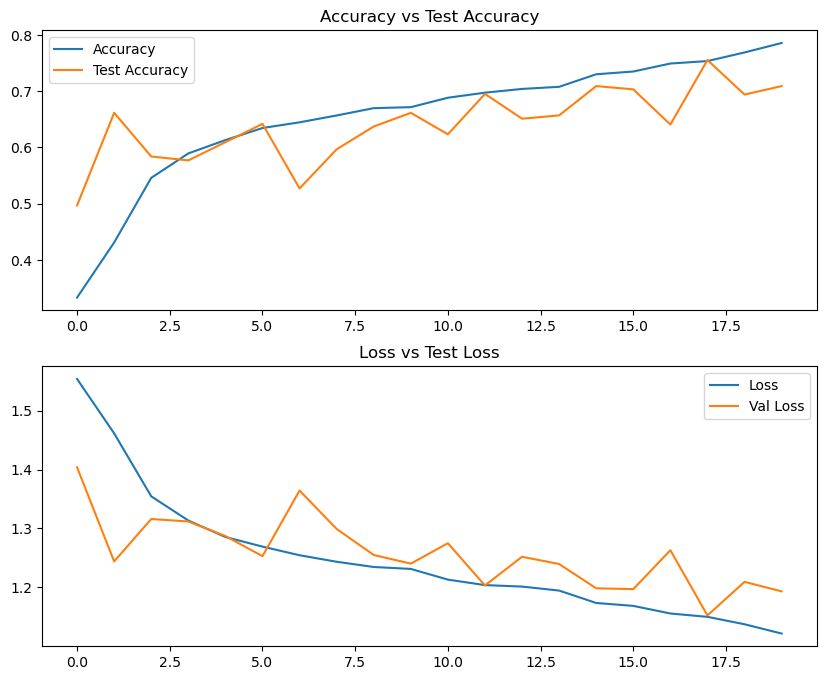

In [14]:
plt.figure(figsize=[10, 8])

plt.subplot(2, 1, 1)
plt.plot(accuracy_arr, label = "Accuracy")
plt.plot(test_accuracy_arr, label = "Test Accuracy")
plt.title("Accuracy vs Test Accuracy")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(loss_arr, label = "Loss")
plt.plot(test_loss_arr, label = "Val Loss")
plt.title("Loss vs Test Loss")
plt.legend()